In [1]:
# Use seaborn for pairplot
!pip install --upgrade pip
!pip install -q seaborn
!pip install -q tensorflow

Traceback (most recent call last):
  File "/usr/bin/pip", line 9, in <module>
    from pip import main
ImportError: cannot import name main
Traceback (most recent call last):
  File "/usr/bin/pip", line 9, in <module>
    from pip import main
ImportError: cannot import name main
Traceback (most recent call last):
  File "/usr/bin/pip", line 9, in <module>
    from pip import main
ImportError: cannot import name main


In [2]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

1.13.1


In [3]:
%load_ext autoreload
%autoreload

import numpy as np
import pandas as pd
import pickle

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, GroupKFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import random

from equationmodel_ann import ann_mlp_regression, prediction_rmse_error, ann_linear_compare_graph, errorDist
from equationmodel_gp import gp_regression, prediction_rmse_error, gp_train_graph, gp_linear_compare_graph
from util import ADD_data_loader, combineDF, filteringDF, getFreeSpacePathLoss, makeXforGraphWithGroupingFrequency,\
                makeXforGraph, inverseScale, samplingData, normalizeData,train_2d_graph, train_3d_graph, groupWithFrequency\
                , train_2d_sigma_graph, train_2d_sigma_graph_s, groupWithFrequency, train_3d_graph_origin, model_3d_graph

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

desired_width=620
pd.set_option('display.width', desired_width)
pd.set_option('display.max_columns',30)
pd.options.display.float_format = "{:.2f}".format

In [4]:
%autoreload

wt_fileList = {'../data/PLdata_paju_wt_400.csv':[('season', 0), ('frequency', 400), ('heightTB',100), ('heightB',7), ('heightM',2)],
            '../data/PLdata_paju_wt_1399.csv':[('season', 0), ('frequency', 1399), ('heightTB',100), ('heightB',7), ('heightM',2)],
            '../data/PLdata_paju_wt_2249.csv':[('season', 0), ('frequency', 2249), ('heightTB',100), ('heightB',7), ('heightM',2)]}
sp_fileList = {'../data/PLdata_paju_sp_400.csv':[('season', 0.5), ('frequency', 400), ('heightTB',100), ('heightB',7), ('heightM',2)],
            '../data/PLdata_paju_sp_1399.csv':[('season', 0.5), ('frequency', 1399), ('heightTB',100), ('heightB',7), ('heightM',2)],
            '../data/PLdata_paju_sp_2249.csv':[('season', 0.5), ('frequency', 2249), ('heightTB',100), ('heightB',7), ('heightM',2)]}
sm_fileList = {'../data/PLdata_paju_sm_400.csv':[('season', 1.0), ('frequency', 400), ('heightTB',100), ('heightB',7), ('heightM',2)],
            '../data/PLdata_paju_sm_1399.csv':[('season', 1.0), ('frequency', 1399), ('heightTB',100), ('heightB',7), ('heightM',2)],
            '../data/PLdata_paju_sm_2249.csv':[('season', 1.0), ('frequency', 2249), ('heightTB',100), ('heightB',7), ('heightM',2)]}

addWt = ADD_data_loader(wt_fileList)
print("winter data:",addWt.shape)
print("")
addSp = ADD_data_loader(sp_fileList)
print("spring data:",addSp.shape)
print("")
addSm = ADD_data_loader(sm_fileList)
print("summer data:",addSm.shape)
print("")

# print(addIksan.describe())
# print(addNonsan.describe())
# print(addPaju.describe())

# addData = combineDF([addWt, addSp, addSm])
addData = addWt
print("antenna_b height filtering-before(data count):",addData.shape)
addData = filteringDF(addData, 'heightTM', [10,100])
print("antenna_b height filtering-after(data count):",addData.shape)

print("freespace pathloss filtering-before(data count):",addData.shape)
addData['freePathloss'] = getFreeSpacePathLoss(addData['distance'],addData['frequency'])
addData = addData[addData['pathloss'] >= addData['freePathloss']]
print("freespace pathloss filtering-after(data count):",addData.shape)

# print("ADD data sample:\n",addData.head())

../data/PLdata_paju_wt_2249.csv: distance filtering(before):(110246, 4)
../data/PLdata_paju_wt_2249.csv: distance filtering(after):(47005, 4)
../data/PLdata_paju_wt_400.csv: distance filtering(before):(110440, 4)
../data/PLdata_paju_wt_400.csv: distance filtering(after):(47125, 4)
../data/PLdata_paju_wt_1399.csv: distance filtering(before):(110358, 4)
../data/PLdata_paju_wt_1399.csv: distance filtering(after):(47071, 4)
        type  distance  pathloss  heightTM  season  frequency  heightTB  heightB  heightM
type 93    m      1.00    107.14      0.02       0       2249       100        7        2
     94    m      1.01    105.75      0.02       0       2249       100        7        2
     95    m      1.01    103.32      0.02       0       2249       100        7        2
     96    m      1.01    103.28      0.02       0       2249       100        7        2
     97    m      1.01    103.61      0.02       0       2249       100        7        2
Combined data set: (141201, 9)
type 

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


data distribution(before)
       logDiagnalDistance  distance  diagnalDistance  frequency  logDistance  logFrequency  logHeightTM  logExtendedHeightTratio   season  pathloss
count            93928.00  93928.00         93928.00   93928.00     93928.00      93928.00     93928.00                 93928.00 93928.00  93928.00
mean                 1.88      3.92            77.54    1349.12         0.55          3.03         1.39                     0.60     0.00    131.51
std                  0.10      1.46            14.20     754.84         0.20          0.32         0.20                     0.19     0.00     15.74
min                  0.75      1.00             5.64     400.00         0.00          2.60         1.00                     0.02     0.00     86.09
25%                  1.85      2.54            70.34     400.00         0.41          2.60         1.24                     0.46     0.00    119.64
50%                  1.91      4.12            82.14    1399.00         0.61          

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2869: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)


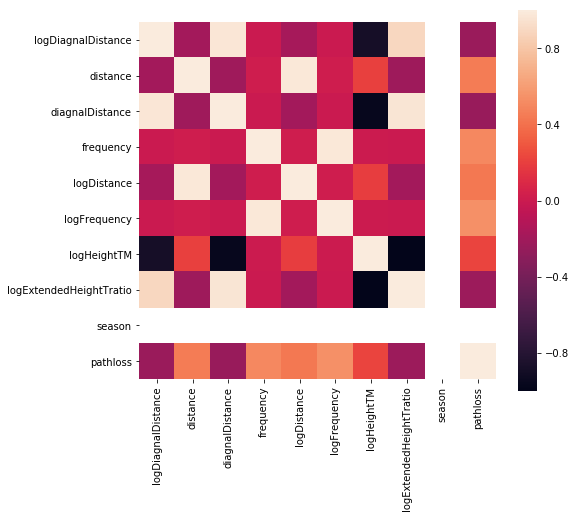

In [5]:
%autoreload

targetCols = ['logDiagnalDistance','distance','diagnalDistance','frequency','logDistance', 'logFrequency', 'logHeightTM', 'logExtendedHeightTratio', 'season', 'pathloss']
yCols = 'pathloss'

samplingRatio = 0.1
addDataSampled = samplingData(addData[targetCols], samplingRatio, None)
# addDataSample.sort_values(by=['logDistance'])

sc = 'paju_5term'
scale = 'manual'

addDataNorm, normalizer = normalizeData(addDataSampled[targetCols], addDataSampled[yCols], scaler = scale)

print("\nADD data description")
print(addDataNorm.describe()['pathloss'])
print("\nCovariance Matrix - ADD data[Target Columns]")
print("Target Columns:", targetCols)
print(addDataNorm.cov()['pathloss'])

print("\nCorrelation Matrix - ADD data[Target Columns]")
print("Target Columns:", targetCols)
corrMat = addDataNorm.corr()
print(corrMat)
f, ax = plt.subplots(figsize=(8,7))
sns.heatmap(corrMat, square=True)


In [6]:
xCols = ['logDistance', 'logFrequency', 'logHeightTM', 'logExtendedHeightTratio', 'season']
yCols = 'pathloss'

X = np.array(addDataNorm[xCols])
Xorigin = np.array(addData[xCols]) 
Y = np.array(addDataSampled[yCols])

pca = PCA(n_components=5)
pca.fit(X)
print(pca.explained_variance_ratio_)  
print(pca.singular_values_) 

[5.89295212e-01 3.98141274e-01 1.25468013e-02 1.67130436e-05
 0.00000000e+00]
[20.95483672 17.22409554  3.05762581  0.11159522  0.        ]


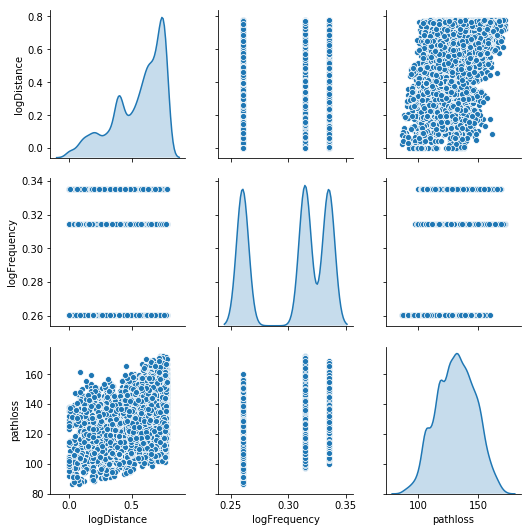

In [7]:
targetXCols = ['logDistance','logFrequency','pathloss']

train_dataset = addDataNorm[targetXCols].sample(frac=0.8, random_state=0)
test_dataset = addDataNorm[targetXCols].drop(train_dataset.index)

sns.pairplot(train_dataset[targetXCols], diag_kind="kde")
plt.show()

In [8]:
train_stats = train_dataset.describe()
train_stats.pop("pathloss")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
logDistance,7514.00,0.55,0.20,0.00,0.40,0.61,0.72,0.78
logFrequency,7514.00,0.30,0.03,0.26,0.26,0.31,0.34,0.34


In [9]:
train_labels = train_dataset.pop('pathloss')
test_labels = test_dataset.pop('pathloss')

In [10]:
linear_model = LinearRegression().fit(train_dataset, train_labels)

train_pred_linear = linear_model.predict(train_dataset)
test_pred_linear = linear_model.predict(test_dataset)

stat = np.array([np.sqrt(mean_squared_error(train_labels, train_pred_linear)), mean_absolute_error(train_labels, train_pred_linear),\
                 mean_absolute_percentage_error(train_labels, train_pred_linear),np.sqrt(mean_squared_log_error(train_labels, train_pred_linear)),\
                 r2_score(train_labels, train_pred_linear),\
                np.sqrt(mean_squared_error(test_labels, test_pred_linear)), mean_absolute_error(test_labels, test_pred_linear),\
                 mean_absolute_percentage_error(test_labels, test_pred_linear),np.sqrt(mean_squared_log_error(test_labels, test_pred_linear)),\
                 r2_score(test_labels, test_pred_linear)])
print(pd.DataFrame(stat.reshape((2,5)),index=pd.Index(['Linear Train','Linear Test']), columns=pd.Index(['RMSE','MAE','MAPE','RMSLE','R2'],name='TEST ERROR(dB)')))

TEST ERROR(dB)  RMSE  MAE  MAPE  RMSLE   R2
Linear Train   11.57 9.44  7.33   0.09 0.47
Linear Test    11.41 9.38  7.29   0.09 0.48


logDistance      0.55
logFrequency     0.26
pathloss       118.98
dtype: float64
logDistance      0.55
logFrequency     0.31
pathloss       136.56
dtype: float64
logDistance      0.56
logFrequency     0.34
pathloss       138.27
dtype: float64


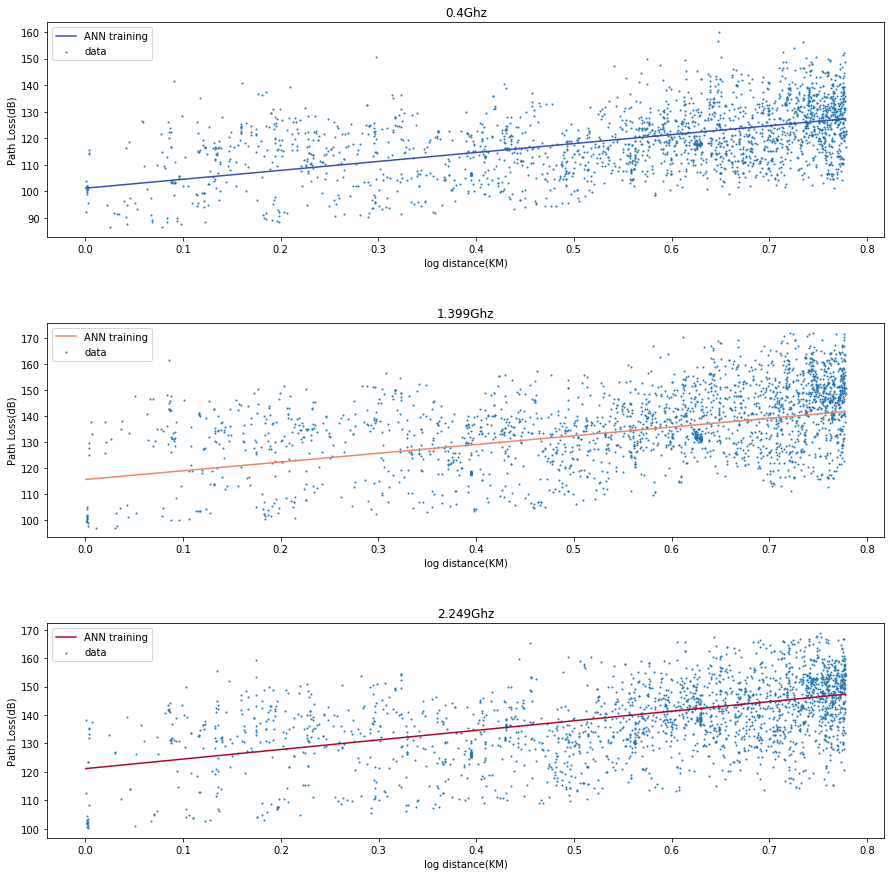

In [11]:
%autoreload
data = makeXforGraphWithGroupingFrequency(train_dataset,
                     pd.DataFrame(train_labels, columns=['pathloss']), [])

graphX = data[0]
graphY = data[1]
train_2d_graph(linear_model, None, None, graphX, graphY, 'logDistance', "log distance(KM)")

In [12]:
# def norm(x):
#     return (x - train_stats['mean']) / train_stats['std']
# def denorm(x):
#     return (x * train_stats['std']) + train_stats['mean']
# normed_train_data = norm(train_dataset)
# normed_test_data = norm(test_dataset)

In [13]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mape',
                optimizer=optimizer,
                metrics=['mse', 'mae', 'mape'])
  return model

In [14]:
ann_model = build_model()

Instructions for updating:
Colocations handled automatically by placer.


In [15]:
ann_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                192       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,417
Trainable params: 4,417
Non-trainable params: 0
_________________________________________________________________


In [16]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

EPOCHS = 1000

history = ann_model.fit(
  train_dataset, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])

Instructions for updating:
Use tf.cast instead.

....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................

In [17]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_absolute_percentage_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_absolute_percentage_error,val_mean_squared_error,epoch
995,7.04,9.11,7.04,131.89,7.01,9.08,7.01,130.81,995
996,7.03,9.11,7.03,131.81,7.00,9.16,7.00,133.77,996
997,7.03,9.10,7.03,131.93,7.05,9.08,7.05,130.58,997
998,7.05,9.13,7.05,132.52,7.01,9.08,7.01,130.75,998
999,7.03,9.10,7.03,131.99,7.00,9.16,7.00,133.69,999


In [18]:
loss, mse, mae, mape = ann_model.evaluate(test_dataset, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} dB".format(mae))
print("Testing set Root Mean Squared Error: {:5.2f} dB".format(mse**.5))
print("Testing set Mean Squared Error: {:5.2f} dB".format(mse))
print("Testing set Mean Absolute Percentage Error: {:5.2f} dB".format(mape))

Testing set Mean Abs Error:  9.16 dB
Testing set Root Mean Squared Error: 11.41 dB
Testing set Mean Squared Error: 130.19 dB
Testing set Mean Absolute Percentage Error:  7.03 dB


In [19]:
train_pred_y = ann_model.predict(train_dataset)
test_pred_y = ann_model.predict(test_dataset)

stat = np.array([np.sqrt(mean_squared_error(train_labels, train_pred_y)), mean_absolute_error(train_labels, train_pred_y),\
                 mean_absolute_percentage_error(train_labels, train_pred_y),np.sqrt(mean_squared_log_error(train_labels, train_pred_y)),\
                 r2_score(train_labels, train_pred_y),\
                np.sqrt(mean_squared_error(test_labels, test_pred_y)), mean_absolute_error(test_labels, test_pred_y),\
                 mean_absolute_percentage_error(test_labels, test_pred_y),np.sqrt(mean_squared_log_error(test_labels, test_pred_y)),\
                 r2_score(test_labels, test_pred_y)])
print(pd.DataFrame(stat.reshape((2,5)),index=pd.Index(['ANN Train','ANN Test']), columns=pd.Index(['RMSE','MAE','MAPE','RMSLE','R2'],name='TEST ERROR(dB)')))

TEST ERROR(dB)  RMSE  MAE  MAPE  RMSLE   R2
ANN Train      11.51 9.11 12.43   0.09 0.47
ANN Test       11.41 9.16 12.44   0.09 0.48


logDistance      0.55
logFrequency     0.26
pathloss       129.53
dtype: float64
logDistance      0.55
logFrequency     0.31
pathloss       129.32
dtype: float64
logDistance      0.56
logFrequency     0.34
pathloss       129.80
dtype: float64


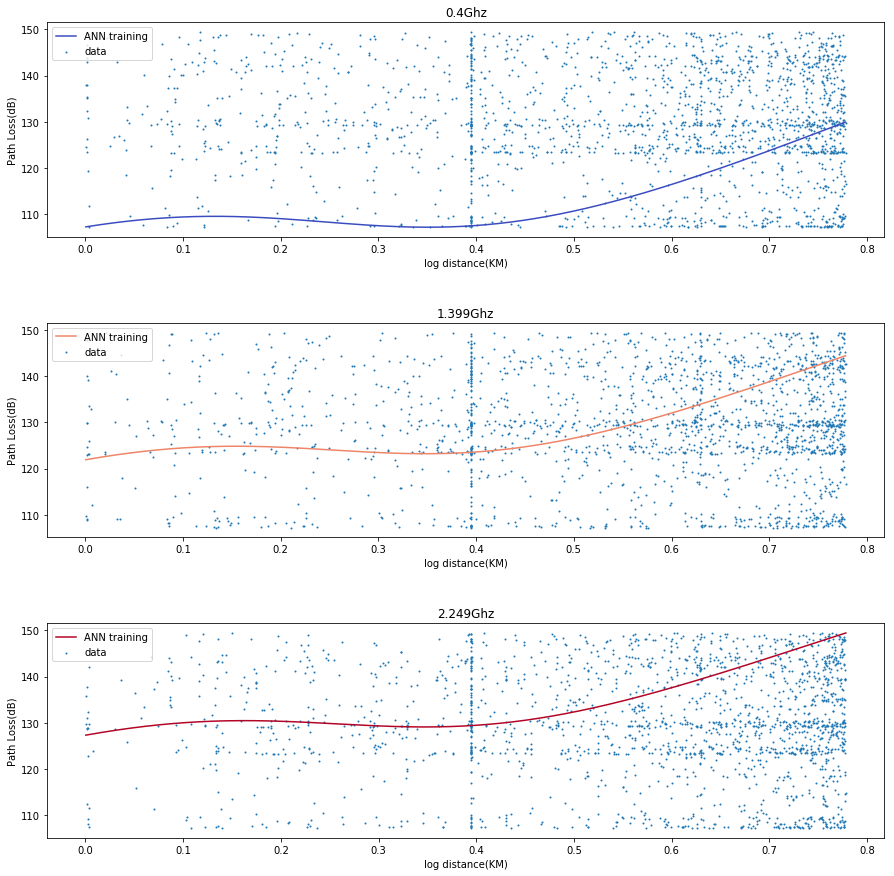

In [20]:
%autoreload
data = makeXforGraphWithGroupingFrequency(train_dataset,
                     pd.DataFrame(train_pred_y, columns=['pathloss']), [])

graphX = data[0]
graphY = data[1]
train_2d_graph(ann_model, None, None, graphX, graphY, 'logDistance', "log distance(KM)")

3D graph for log distance and log frequency
logDistance      0.55
logFrequency     0.30
pathloss       131.31
dtype: float64
Index(['logDistance', 'logFrequency'], dtype='object')
input data/feature distribution:
        logDistance  logFrequency
count     10000.00      10000.00
mean          0.39          0.30
std           0.23          0.02
min           0.00          0.26
25%           0.19          0.28
50%           0.39          0.30
75%           0.58          0.32
max           0.78          0.34


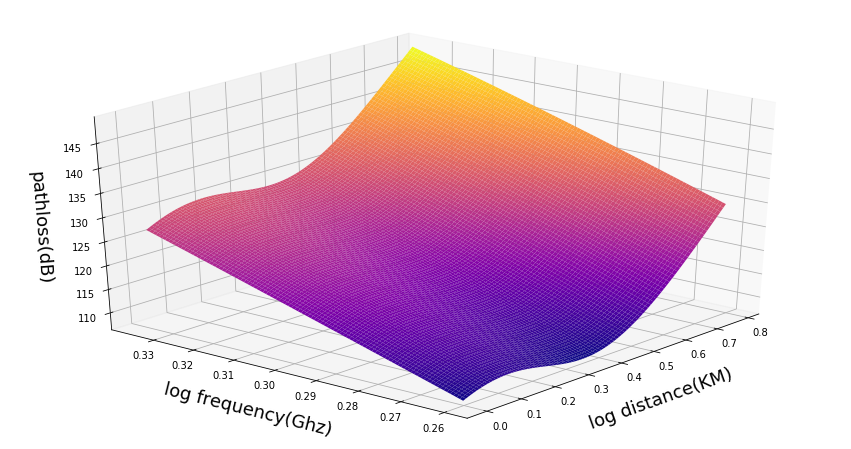

In [21]:
%autoreload
i = 1
print("3D graph for log distance and log frequency")
targetCols = ['logDistance', 'logFrequency']
xLabel,yLabel,zLabel = "log distance(KM)","log frequency(Ghz)","pathloss(dB)"
data = makeXforGraph(train_dataset,
                     pd.DataFrame(train_labels, columns=['pathloss']), targetCols)

graphX = data[0]
graphY = data[1]
x,y,z = train_3d_graph(ann_model, graphX, graphY, targetCols, xLabel, yLabel, zLabel)

# Gaussian Process

In [22]:
kernel = 'RBF'

gp_model_10 = gp_regression(kernel, 10.0)
gp_model_10.fit(train_dataset, train_labels)

train_pred, train_std = gp_model_10.predict(train_dataset, return_std=True)
test_pred, test_std = gp_model_10.predict(test_dataset, return_std=True)

stat = np.array([np.sqrt(mean_squared_error(train_labels, train_pred)), mean_absolute_error(train_labels, train_pred),\
                 mean_absolute_percentage_error(train_labels, train_pred),np.sqrt(mean_squared_log_error(train_labels, train_pred)),\
                 r2_score(train_labels, train_pred),\
                np.sqrt(mean_squared_error(test_labels, test_pred)), mean_absolute_error(test_labels, test_pred),\
                 mean_absolute_percentage_error(test_labels, test_pred),np.sqrt(mean_squared_log_error(test_labels, test_pred)),\
                 r2_score(test_labels, test_pred)])
print(pd.DataFrame(stat.reshape((2,5)),index=pd.Index(['GP Train','GP Test']), columns=pd.Index(['RMSE','MAE','MAPE','RMSLE','R2'],name='TEST ERROR(dB)')))

TEST ERROR(dB)  RMSE  MAE  MAPE  RMSLE   R2
GP Train       10.29 7.88  6.10   0.08 0.58
GP Test        11.13 8.55  6.65   0.09 0.50


In [ ]:
%autoreload
data = makeXforGraphWithGroupingFrequency(train_dataset,
                     pd.DataFrame(train_pred_y, columns=['pathloss']), [])

graphX = data[0]
graphY = data[1]
train_2d_graph(gp_model_10, None, None, graphX, graphY, 'logDistance', "log distance(KM)", sigma = True)

In [24]:
# dataset = pd.DataFrame({'logDistance': x.flatten(), 'logFrequency': y.flatten(), 'pathloss': z.flatten()}, columns=['logDistance', 'logFrequency','pathloss'])
# print(dataset.describe())
# samplingRatio = 0.01
# addDataSampled = samplingData(dataset, samplingRatio, None)
# labelset = addDataSampled.pop('pathloss')

In [25]:
kernel = 'RBF'

gp_model_1 = gp_regression(kernel, 1.0)
gp_model_1.fit(train_dataset, train_labels)

train_pred, train_std = gp_model_1.predict(train_dataset, return_std=True)
test_pred, test_std = gp_model_1.predict(test_dataset, return_std=True)

stat = np.array([np.sqrt(mean_squared_error(train_labels, train_pred)), mean_absolute_error(train_labels, train_pred),\
                 mean_absolute_percentage_error(train_labels, train_pred),np.sqrt(mean_squared_log_error(train_labels, train_pred)),\
                 r2_score(train_labels, train_pred),\
                np.sqrt(mean_squared_error(test_labels, test_pred)), mean_absolute_error(test_labels, test_pred),\
                 mean_absolute_percentage_error(test_labels, test_pred),np.sqrt(mean_squared_log_error(test_labels, test_pred)),\
                 r2_score(test_labels, test_pred)])
print(pd.DataFrame(stat.reshape((2,5)),index=pd.Index(['GP Train','GP Test']), columns=pd.Index(['RMSE','MAE','MAPE','RMSLE','R2'],name='TEST ERROR(dB)')))

TEST ERROR(dB)  RMSE  MAE  MAPE  RMSLE   R2
GP Train       10.29 7.88  6.10   0.08 0.58
GP Test        11.13 8.55  6.65   0.09 0.50


logDistance      0.55
logFrequency     0.26
pathloss       129.53
dtype: float64
logDistance      0.55
logFrequency     0.31
pathloss       129.32
dtype: float64
logDistance      0.56
logFrequency     0.34
pathloss       129.80
dtype: float64


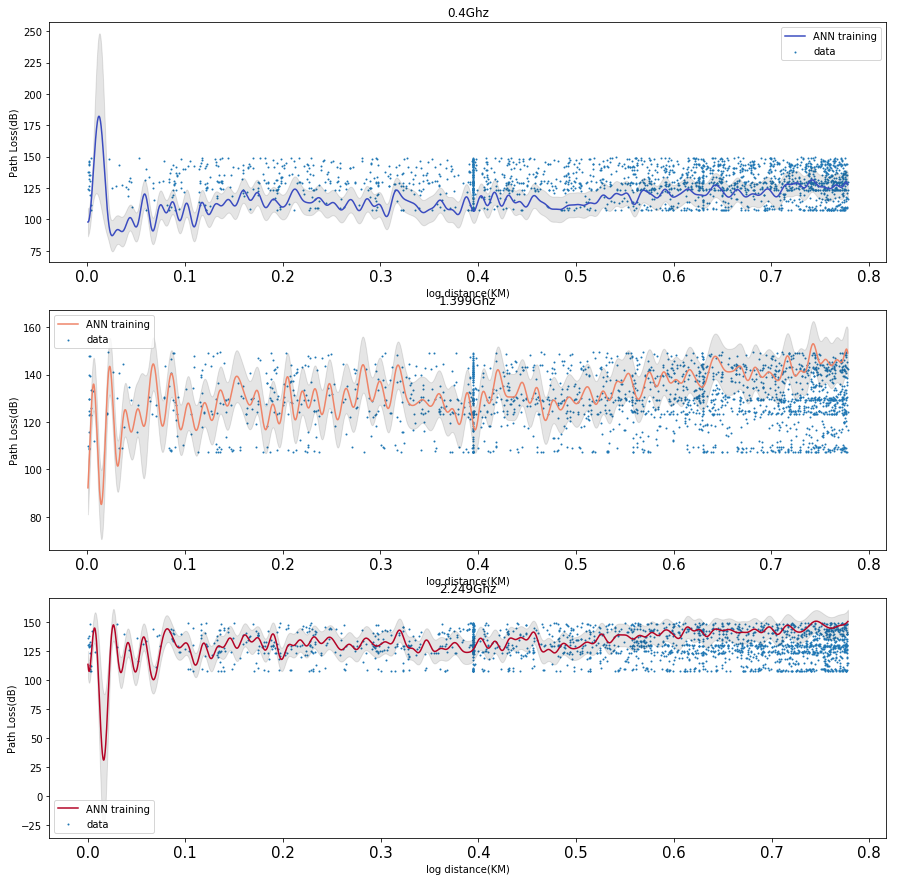

In [26]:
%autoreload
data = makeXforGraphWithGroupingFrequency(train_dataset,
                     pd.DataFrame(train_pred_y, columns=['pathloss']), [])

graphX = data[0]
graphY = data[1]
train_2d_graph(gp_model_1, None, None, graphX, graphY, 'logDistance', "log distance(KM)", sigma = True)

In [27]:
kernel = 'RBF'

gp_model_100 = gp_regression(kernel, 100.0)
gp_model_100.fit(train_dataset, train_labels)

train_pred, train_std = gp_model_100.predict(train_dataset, return_std=True)
test_pred, test_std = gp_model_100.predict(test_dataset, return_std=True)

stat = np.array([np.sqrt(mean_squared_error(train_labels, train_pred)), mean_absolute_error(train_labels, train_pred),\
                 mean_absolute_percentage_error(train_labels, train_pred),np.sqrt(mean_squared_log_error(train_labels, train_pred)),\
                 r2_score(train_labels, train_pred),\
                np.sqrt(mean_squared_error(test_labels, test_pred)), mean_absolute_error(test_labels, test_pred),\
                 mean_absolute_percentage_error(test_labels, test_pred),np.sqrt(mean_squared_log_error(test_labels, test_pred)),\
                 r2_score(test_labels, test_pred)])
print(pd.DataFrame(stat.reshape((2,5)),index=pd.Index(['GP Train','GP Test']), columns=pd.Index(['RMSE','MAE','MAPE','RMSLE','R2'],name='TEST ERROR(dB)')))

TEST ERROR(dB)  RMSE  MAE  MAPE  RMSLE   R2
GP Train       10.29 7.88  6.10   0.08 0.58
GP Test        11.13 8.55  6.65   0.09 0.50


logDistance      0.55
logFrequency     0.26
pathloss       129.53
dtype: float64
logDistance      0.55
logFrequency     0.31
pathloss       129.32
dtype: float64
logDistance      0.56
logFrequency     0.34
pathloss       129.80
dtype: float64


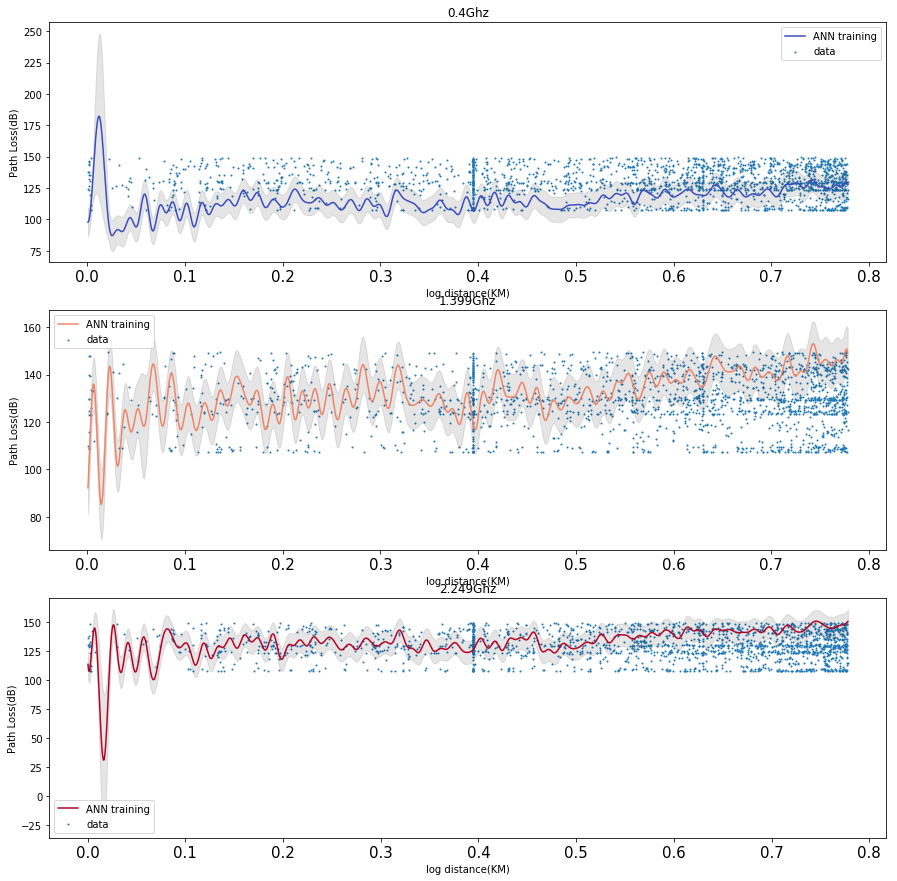

In [28]:
%autoreload
data = makeXforGraphWithGroupingFrequency(train_dataset,
                     pd.DataFrame(train_pred_y, columns=['pathloss']), [])

graphX = data[0]
graphY = data[1]
train_2d_graph(gp_model_100, None, None, graphX, graphY, 'logDistance', "log distance(KM)", sigma = True)

In [29]:
# kernel = 'RBF'

# model = gp_regression(kernel)
# model.fit(addDataSampled, labelset)

# pred, std = model.predict(addDataSampled, return_std=True)
# print(std)

3D graph for log distance and log frequency
logDistance      0.55
logFrequency     0.30
pathloss       131.31
dtype: float64
Index(['logDistance', 'logFrequency'], dtype='object')
input data/feature distribution:
        logDistance  logFrequency
count     10000.00      10000.00
mean          0.39          0.30
std           0.23          0.02
min           0.00          0.26
25%           0.19          0.28
50%           0.39          0.30
75%           0.58          0.32
max           0.78          0.34


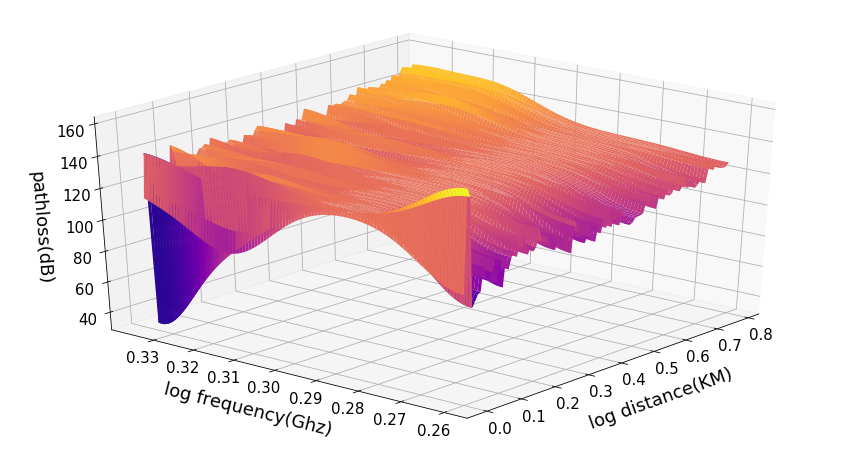

In [30]:
print("3D graph for log distance and log frequency")
targetCols = ['logDistance', 'logFrequency']
xLabel,yLabel,zLabel = "log distance(KM)","log frequency(Ghz)","pathloss(dB)"
data = makeXforGraph(train_dataset,
                     pd.DataFrame(train_labels, columns=['pathloss']), targetCols)

graphX = data[0]
graphY = data[1]
x,y,z = train_3d_graph(gp_model_100, graphX, graphY, targetCols, xLabel, yLabel, zLabel)

In [31]:
# %autoreload
# print("3D graph for log distance and log frequency")
# targetCols = ['logDistance', 'logFrequency']
# xLabel,yLabel,zLabel = "log distance(KM)","log frequency(Ghz)","pathloss(dB)"
# train_3d_graph_origin(model, addDataSampled, std, targetCols)

In [32]:
%autoreload
print("3D graph for log distance and log frequency")
labels = ["log distance(KM)","log frequency(Ghz)","pathloss(dB)"]

org_x = np.array(train_dataset['logDistance'])
org_y = np.array(train_dataset['logFrequency'])
org_z = train_labels

totalPoint = 100

minX = min(org_x)
maxX = max(org_x)
linX = np.linspace(minX, maxX, num=totalPoint)
minY = min(org_y)
maxY = max(org_y)
linY = np.linspace(minY, maxY, num=totalPoint)

x, y = np.meshgrid(linX, linY)
xFlat, yFlat = x.flatten(), y.flatten()
dataset = pd.DataFrame({'logDistance': xFlat, 'logFrequency': yFlat}, columns=['logDistance', 'logFrequency'])
z, std = gp_model.predict(dataset, return_std=True)
z = z.reshape(x.shape)
std = std.reshape(x.shape)
print("x shape",x.shape)
print("y shape",y.shape)
print("z shape",z.shape)
model_3d_graph(x, y, z, org_x, org_y, org_z)

model_3d_graph(x, y, std, org_x, org_y, org_z)

3D graph for log distance and log frequency


NameError: name 'gp_model' is not defined